# Image Colorization

1. Adopt the implementation of the U-Net network from the previous task and train it on the task of image colorization.
2. Remove the skip connections of the implemented U-Net network, retrain it on the colorization task and examine the difference.

In [ ]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
      center = factor - 1
    else:
      center = factor - 0.5

    og = (torch.arange(kernel_size).reshape(-1, 1), torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels, kernel_size, kernel_size))
    for i in range(out_channels):
        weight[i, i % in_channels, :, :] = filt

    return weight

In [ ]:
class UNetBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(UNetBlock, self).__init__()

    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
    self.batchnorm1 = nn.BatchNorm2d(out_channels)

    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
    self.batchnorm2 = nn.BatchNorm2d(out_channels)


  def forward(self, x):
    c1 = self.conv1(x)
    bn1 = self.batchnorm1(c1)
    a1 = nn.functional.relu(bn1)

    c2 = self.conv2(a1)
    bn2 = self.batchnorm2(c2)
    out = nn.functional.relu(bn2)

    return out

In [ ]:
class UNetEncoderBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(UNetEncoderBlock, self).__init__()
    self.resblock = UNetBlock(in_channels, out_channels)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)


  def forward(self, x):
    rb = self.resblock(x)
    out = self.pool(rb)

    return rb, out

In [ ]:
class UNetDecoderBlock(nn.Module):
  def __init__(self, in_channels, out_channels, skip_connections):
    super(UNetDecoderBlock, self).__init__()
    self.transposeconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
    self.transposeconv.weight.data.copy_(bilinear_kernel(in_channels, out_channels, kernel_size=2))
    self.resblock = UNetBlock(2*out_channels, out_channels)

    if skip_connections == True:
      self.resblock = UNetBlock(2*out_channels, out_channels)
    else:
      self.resblock = UNetBlock(out_channels, out_channels)
    self.skip_connections = skip_connections


  def forward(self, x, residual):
    tc = self.transposeconv(x)

    if self.skip_connections == True:
      out = self.resblock(torch.cat([tc, residual], axis=1))
    else:
      out = self.resblock(tc)

    return out

In [ ]:
class UNet(nn.Module):
  def __init__(self, img_channels, num_classes, skip_connections=True):
    super(UNet, self).__init__()
    self.encoder1 = UNetEncoderBlock(in_channels=img_channels, out_channels=64)
    self.encoder2 = UNetEncoderBlock(in_channels=64, out_channels=128)
    self.encoder3 = UNetEncoderBlock(in_channels=128, out_channels=256)
    self.encoder4 = UNetEncoderBlock(in_channels=256, out_channels=512)

    self.bottleneck = UNetBlock(in_channels=512, out_channels=1024)

    self.decoder1 = UNetDecoderBlock(in_channels=1024, out_channels=512, skip_connections=skip_connections)
    self.decoder2 = UNetDecoderBlock(in_channels=512, out_channels=256, skip_connections=skip_connections)
    self.decoder3 = UNetDecoderBlock(in_channels=256, out_channels=128, skip_connections=skip_connections)
    self.decoder4 = UNetDecoderBlock(in_channels=128, out_channels=64, skip_connections=skip_connections)

    self.conv = nn.Conv2d(64, num_classes, kernel_size=1, bias=False)
    self.batchnorm = nn.BatchNorm2d(num_classes)

    for module in self.modules():
      if isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight, mode="fan_out", nonlinearity="relu")
      elif isinstance(module, nn.BatchNorm2d):
        nn.init.ones_(module.weight)
        nn.init.zeros_(module.bias)


  def forward(self, x):
    e1_residual, e1 = self.encoder1(x)
    e2_residual, e2 = self.encoder2(e1)
    e3_residual, e3 = self.encoder3(e2)
    e4_residual, e4 = self.encoder4(e3)

    b = self.bottleneck(e4)

    d1 = self.decoder1(b, e4_residual)
    d2 = self.decoder2(d1, e3_residual)
    d3 = self.decoder3(d2, e2_residual)
    d4 = self.decoder4(d3, e1_residual)

    conv = self.conv(d4)
    out = self.batchnorm(conv)

    return out

## Download the dataset from google drive:

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown  --id 1gS35-TyG0EEcTGes-WtglcVl2Ij4WGT0
# use the other file id if the first one doesn't work
#!gdown  --id 1Q0UIc27o6qlFAqNiDKfM06KwpzHCGKLU
!unzip -q landscapes.zip -d ./data

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1gS35-TyG0EEcTGes-WtglcVl2Ij4WGT0
From (redirected): https://drive.google.com/uc?id=1gS35-TyG0EEcTGes-WtglcVl2Ij4WGT0&confirm=t&uuid=0eda97fc-2d19-4bf7-9ce9-4a3f440284e1
To: /content/landscapes.zip
100% 650M/650M [00:09<00:00, 70.8MB/s]


## Colorization dataset

The dataset class loads the image and also converts them to a grayscale version. The image pair is then used for training.

In [ ]:
class ColorizationDataset(Dataset):

    def __init__(self, train=True):
        self.all_images = sorted(glob.glob("./data/*"))
        self.images = self.all_images[:-500]
        self.test_images = self.all_images[-500:]
        if not train:
          self.images = self.test_images

        self.resize_shape = (256, 256)

    def __len__(self):
        return len(self.images)

    def transform_image(self, image_path):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)

        channels=3
        image = cv2.resize(image, dsize=(self.resize_shape[1], self.resize_shape[0]))
        gray_image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
        image = np.array(image).reshape((image.shape[0], image.shape[1], channels)).astype(np.float32) / 255.0
        gray_image = np.array(gray_image).reshape((image.shape[0], image.shape[1], 1)).astype(np.float32) / 255.0

        image = np.transpose(image, (2, 0, 1))
        gray_image = np.transpose(gray_image, (2, 0, 1))
        return image, gray_image

    def __getitem__(self, idx):
        image, gray_image = self.transform_image(self.images[idx])
        sample = {'image': image, "gray_image": gray_image, 'idx': idx}

        return sample

## Examples of the training image pairs

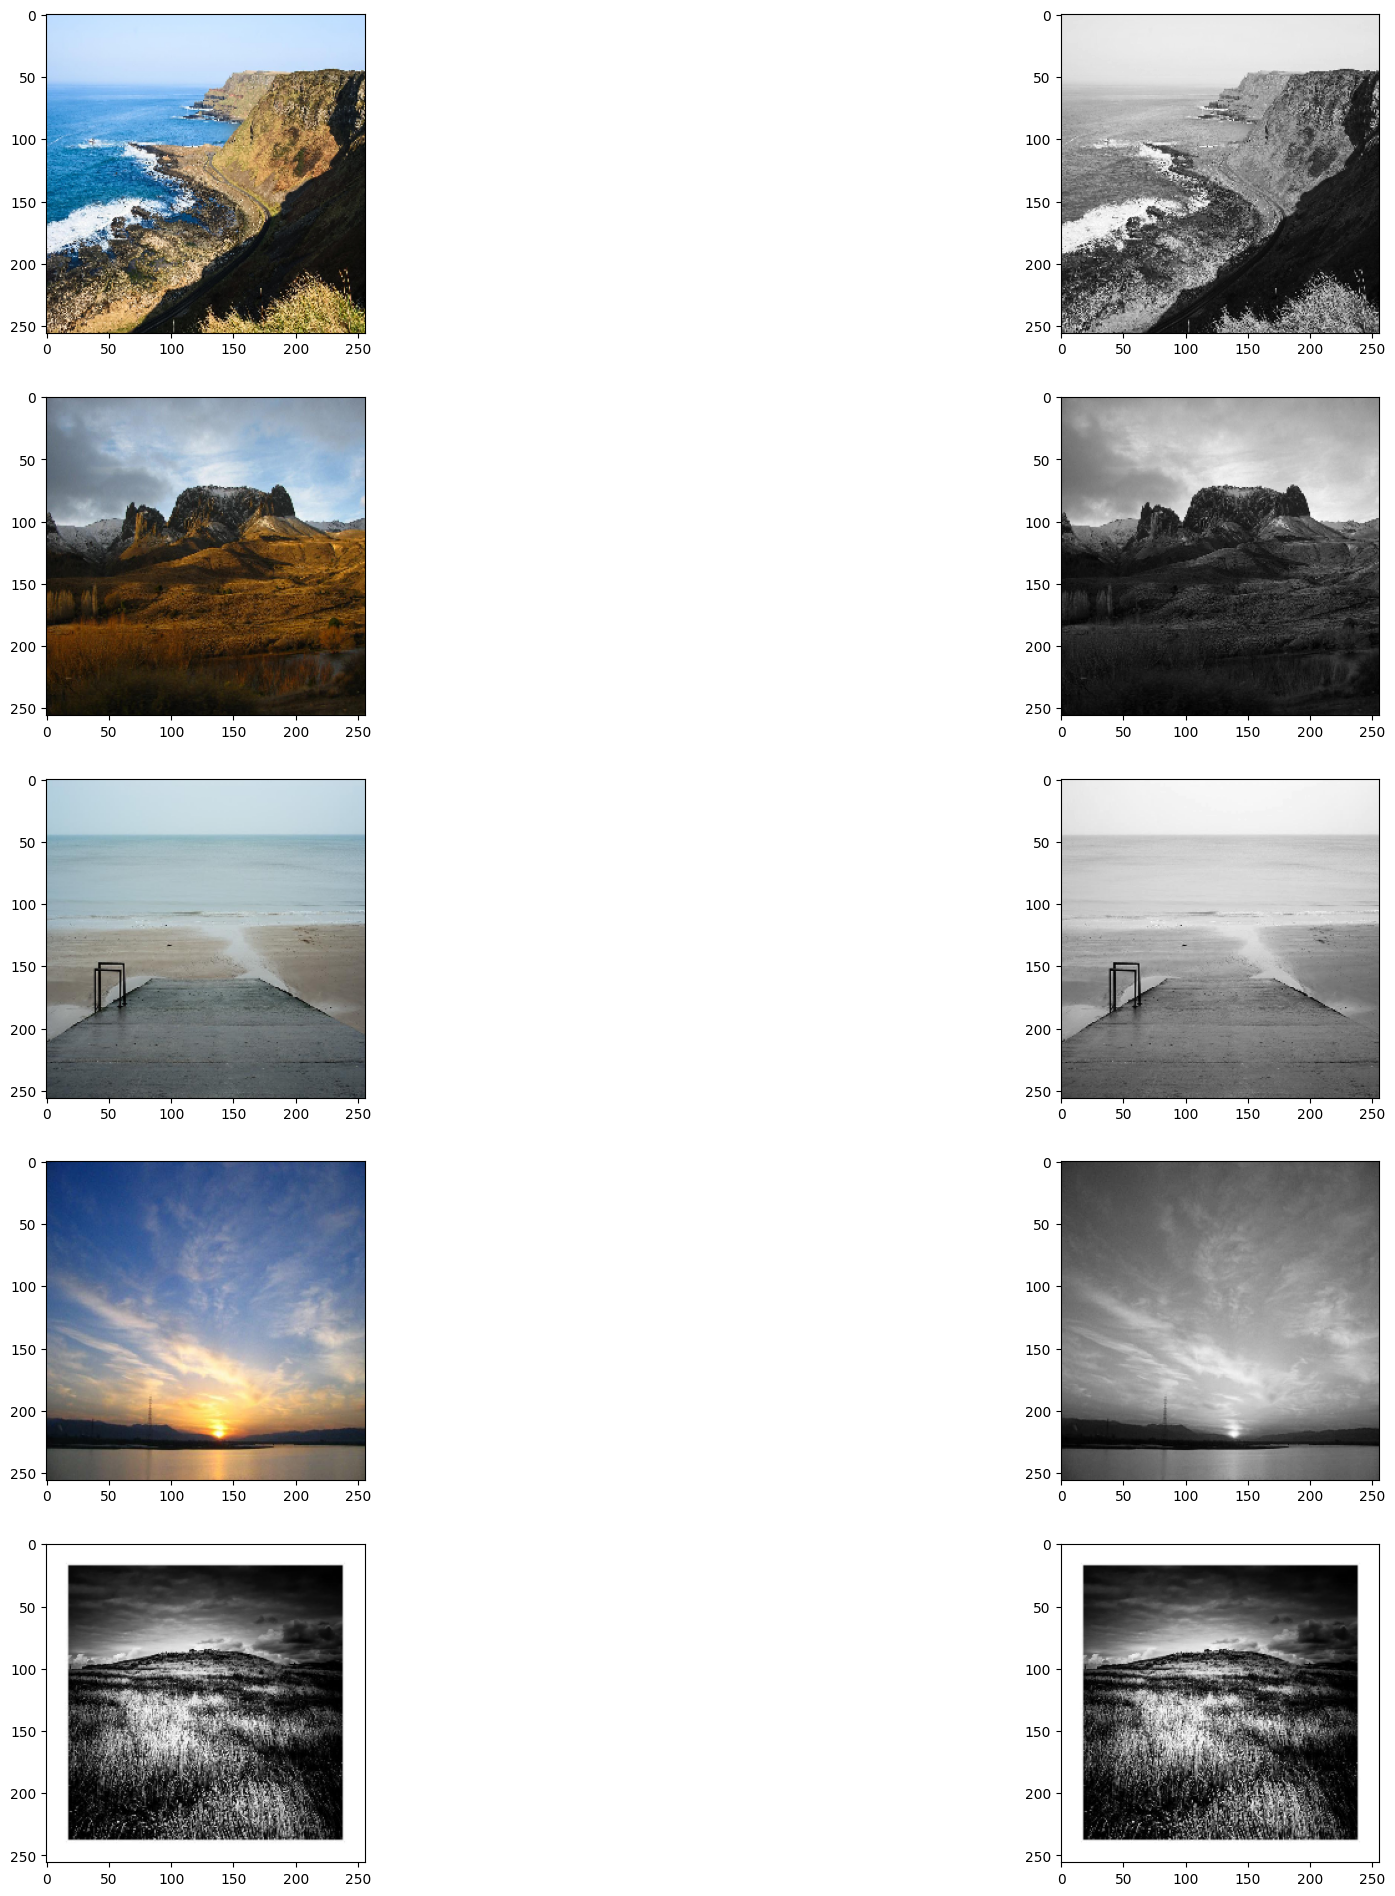

In [ ]:
trainset = ColorizationDataset(train=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = ColorizationDataset(train=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

fig=plt.figure(figsize=(24, 24))
columns = 2
rows = 5
for i in range(rows):
  batch = trainset[np.random.randint(len(trainset))]
  img = batch['image'].transpose((1,2,0))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  gray = batch['gray_image'][0,:,:]
  fig.add_subplot(rows, columns, i*columns+1)
  plt.imshow(img)
  fig.add_subplot(rows, columns, i*columns+2)
  plt.imshow(gray,cmap='gray')
plt.show()

## Training loop


In [ ]:
net = UNet(img_channels=1, num_classes=3, skip_connections=False)
net.cuda()

optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-5)

epochs=20
val_loss_min_simple = np.Inf
train_loss_simple = []
unet_simple = None

for epoch in range(epochs):  # loop over the dataset multiple times
  train_loss = 0.0
  total = 0
  total_step = len(trainloader)
  with tqdm(total=len(trainset), desc ='Epoch: '+str(epoch)+"/"+str(epochs), unit='img') as prog_bar:
    for i, data in enumerate(trainloader, 0):
      # get the inputs;
      gray_images = data["gray_image"]
      color_images = data["image"]

      # Get the inputs to the GPU
      gray_images = gray_images.cuda()
      color_images = color_images.cuda()

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(gray_images)
      loss = nn.functional.l1_loss(outputs, color_images)
      train_loss += loss.item()

      loss.backward()
      optimizer.step()

      prog_bar.set_postfix(**{'loss': loss.data.cpu().detach().numpy()})
      prog_bar.update(4)

  epoch_loss = train_loss / total_step
  train_loss_simple.append(epoch_loss)
  print(f'\ntraining loss: {epoch_loss:.4f}')

  improvement = epoch_loss < val_loss_min_simple
  if improvement:
    val_loss_min_simple = epoch_loss
    unet_simple = net
    print("IMPROVEMENT")

Epoch: 0/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1370
IMPROVEMENT


Epoch: 1/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1290
IMPROVEMENT


Epoch: 2/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1263
IMPROVEMENT


Epoch: 3/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1221
IMPROVEMENT


Epoch: 4/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1267


Epoch: 5/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1258


Epoch: 6/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1205
IMPROVEMENT


Epoch: 7/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1221


Epoch: 8/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1237


Epoch: 9/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1194
IMPROVEMENT


Epoch: 10/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1237


Epoch: 11/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1215


Epoch: 12/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1206


Epoch: 13/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1212


Epoch: 14/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1223


Epoch: 15/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1198


Epoch: 16/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1201


Epoch: 17/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1213


Epoch: 18/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1196


Epoch: 19/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1198


In [ ]:
net = UNet(img_channels=1, num_classes=3, skip_connections=True)
net.cuda()

optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-5)

epochs=20
val_loss_min_skip = np.Inf
train_loss_skip = []
unet_skip = None

for epoch in range(epochs):  # loop over the dataset multiple times
  train_loss = 0.0
  total = 0
  total_step = len(trainloader)
  with tqdm(total=len(trainset), desc ='Epoch: '+str(epoch)+"/"+str(epochs), unit='img') as prog_bar:
    for i, data in enumerate(trainloader, 0):
      # get the inputs;
      gray_images = data["gray_image"]
      color_images = data["image"]

      # Get the inputs to the GPU
      gray_images = gray_images.cuda()
      color_images = color_images.cuda()

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(gray_images)
      loss = nn.functional.l1_loss(outputs, color_images)
      train_loss += loss.item()

      loss.backward()
      optimizer.step()

      prog_bar.set_postfix(**{'loss': loss.data.cpu().detach().numpy()})
      prog_bar.update(4)

  epoch_loss = train_loss / total_step
  train_loss_skip.append(epoch_loss)
  print(f'\ntraining loss: {epoch_loss:.4f}')

  improvement = epoch_loss < val_loss_min_skip
  if improvement:
    val_loss_min_skip = epoch_loss
    unet_skip = net
    print("IMPROVEMENT")

Epoch: 0/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1197
IMPROVEMENT


Epoch: 1/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1116
IMPROVEMENT


Epoch: 2/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1099
IMPROVEMENT


Epoch: 3/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1101


Epoch: 4/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1122


Epoch: 5/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1091
IMPROVEMENT


Epoch: 6/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1089
IMPROVEMENT


Epoch: 7/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1071
IMPROVEMENT


Epoch: 8/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1083


Epoch: 9/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1113


Epoch: 10/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1096


Epoch: 11/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1109


Epoch: 12/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1098


Epoch: 13/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1102


Epoch: 14/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1045
IMPROVEMENT


Epoch: 15/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1115


Epoch: 16/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1093


Epoch: 17/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1055


Epoch: 18/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1075


Epoch: 19/20:   0%|          | 0/3819 [00:00<?, ?img/s]


training loss: 0.1055


## Display output examples from the test set

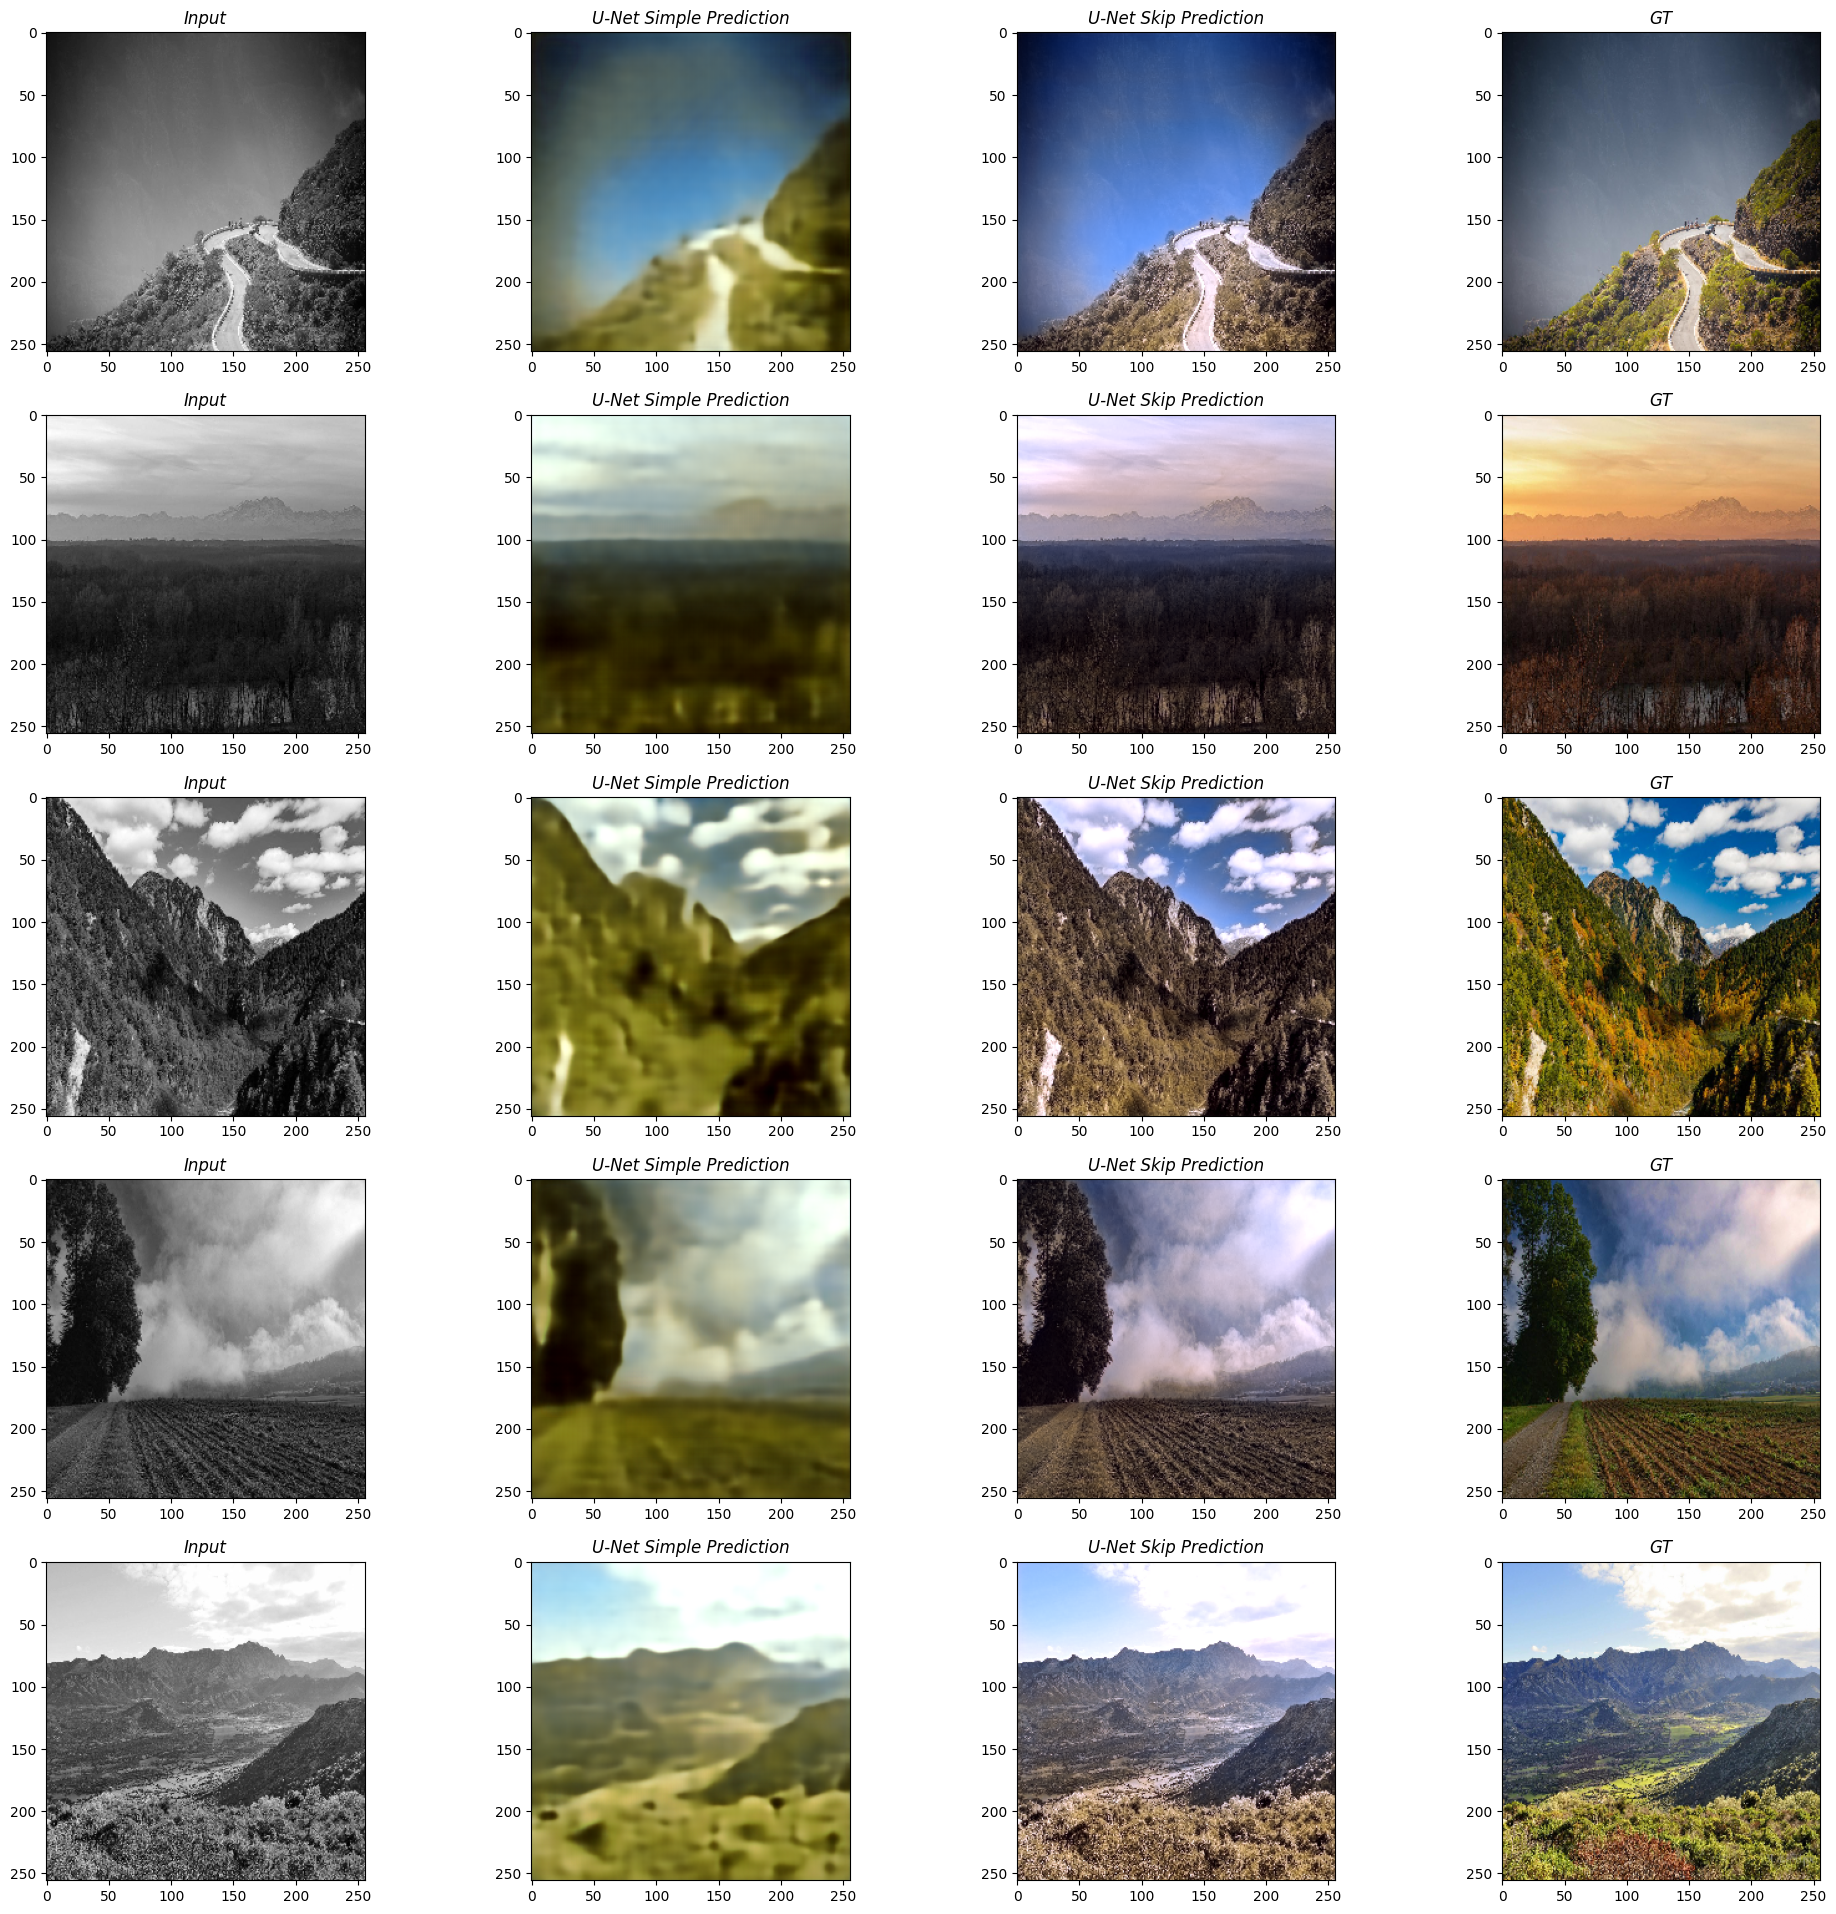

In [27]:
unet_simple.eval()
unet_skip.eval()

fig=plt.figure(figsize=(24, 24))
columns = 4
rows = 5

for i in range(rows):
  batch = testset[i+40]
  img = batch['image']
  gray = batch['gray_image']
  img_tensor = torch.from_numpy(gray).cuda().unsqueeze(0)

  outputs_simple = unet_simple(img_tensor)
  out_image_simple = cv2.cvtColor(outputs_simple[0,:,:,:].detach().cpu().numpy().transpose((1,2,0)), cv2.COLOR_BGR2RGB)

  outputs_skip = unet_skip(img_tensor)
  out_image_skip = cv2.cvtColor(outputs_skip[0,:,:,:].detach().cpu().numpy().transpose((1,2,0)), cv2.COLOR_BGR2RGB)

  img=img.transpose((1,2,0))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  gray = gray[0,:,:]

  ax = fig.add_subplot(rows, columns, i*columns+1)
  ax.set_title("Input", fontstyle='italic')
  plt.imshow(gray, cmap='gray')


  ax = fig.add_subplot(rows, columns, i*columns+2)
  ax.set_title("U-Net Simple Prediction", fontstyle='italic')
  plt.imshow(out_image_simple)

  ax = fig.add_subplot(rows, columns, i*columns+3)
  ax.set_title("U-Net Skip Prediction", fontstyle='italic')
  plt.imshow(out_image_skip)

  ax = fig.add_subplot(rows, columns, i*columns+4)
  ax.set_title("GT", fontstyle='italic')
  plt.imshow(img)

plt.show()

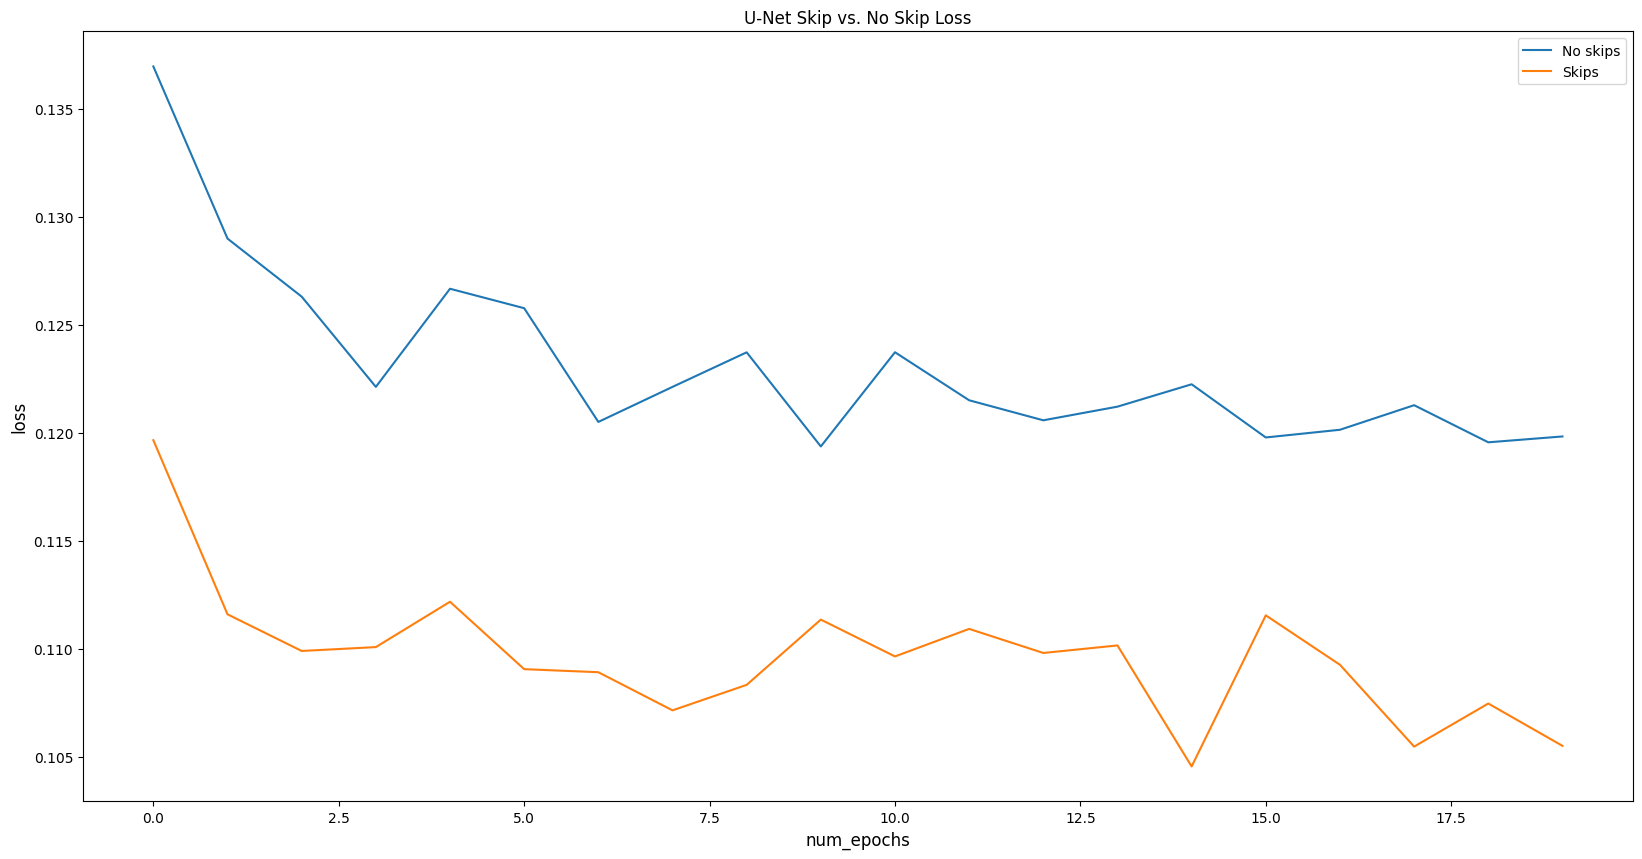

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("U-Net Skip vs. No Skip Loss")
plt.plot(train_loss_simple, label='No skips')
plt.plot(train_loss_skip, label='Skips')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

nets = [unet_simple, unet_skip]

for i in range(len(nets)):
    net = nets[i]
    net.eval()
    psnr_scores = []
    ssim_scores = []

    with torch.no_grad():
        for j, data in enumerate(testloader, 0):
            # get the inputs;
            gray_images = data["gray_image"]
            color_images = data["image"]

            # Get the inputs to the GPU
            gray_images = gray_images.cuda()
            color_images = color_images.cuda()

            outputs = net(gray_images)

            # Calculate PSNR and SSIM
            for k in range(len(outputs)):
                predicted = outputs[k].detach().cpu().numpy().transpose(1, 2, 0)
                target = color_images[k].cpu().numpy().transpose(1, 2, 0)

                psnr_score = psnr(np.clip(predicted, 0, 1), target)
                ssim_score = ssim(np.clip(predicted, 0, 1), target, multichannel=True)

                psnr_scores.append(psnr_score)
                ssim_scores.append(ssim_score)

    mean_psnr = np.mean(psnr_scores)
    mean_ssim = np.mean(ssim_scores)

    if i == 0:
        print(f"The Mean PSNR of U-Net without skips is: {mean_psnr:.2f}.")
        print(f"The Mean SSIM of U-Net without skips is: {mean_ssim:.4f}.")
    else:
        print(f"The Mean PSNR of U-Net with skips is: {mean_psnr:.2f}.")
        print(f"The Mean SSIM of U-Net with skips is: {mean_ssim:.4f}.")

<ipython-input-22-2c48951534cc>:30: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = ssim(np.clip(predicted, 0, 1), target, multichannel=True)


The Mean PSNR of U-Net without skips is: 17.83.
The Mean SSIM of U-Net without skips is: 0.6362.
The Mean PSNR of U-Net with skips is: 20.01.
The Mean SSIM of U-Net with skips is: 0.9218.
